# Setup Model Repo

In [1]:
!rm models -rf
!git lfs install
!git clone https://huggingface.co/sid220/asl-now-fingerspelling if_models
import os
import shutil
import fnmatch

def delete_files_except_git_and_readme(directory):
    # Ensure the directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' not found.")
        return

    # List all files and folders in the directory
    for root, dirs, files in os.walk(directory, topdown=True):
        # Exclude the .git directory and its contents
        dirs[:] = [d for d in dirs if not fnmatch.fnmatch(d, '.git')]

        for file in files + dirs:
            # Skip files starting with .git
            if file.startswith('.git'):
                continue

            # Skip README.md
            if file.lower() == 'readme.md':
                continue

            # Construct the full path
            file_path = os.path.join(root, file)

            # Check if it's a directory or file and delete accordingly
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Deleted directory: {file_path}")
            else:
                os.remove(file_path)
                print(f"Deleted file: {file_path}")
                
delete_files_except_git_and_readme("if_models")

Updated Git hooks.
Git LFS initialized.
Cloning into 'if_models'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), 486 bytes | 486.00 KiB/s, done.


# Imports

In [2]:
!pip install visualkeras


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sklearn.model_selection
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import string
import pandas as pd
import cv2
import seaborn as sn
import visualkeras
from PIL import ImageFont
import json
from pathlib import Path
import tensorflowjs as tfjs
import time
import random
import sklearn

2023-12-22 14:22:42.128640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 14:22:42.130659: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 14:22:42.156119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 14:22:42.156141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 14:22:42.156846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Data Prep

In [4]:
VERSION = "3"
DATADIR = Path("/home/sid/Datasets/asl-now/")

In [5]:
label_map = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "H": 7,
    "I": 8,
    "J": 9,
    "K": 10,
    "L": 11,
    "M": 12,
    "N": 13,
    "O": 14,
    "P": 15,
    "Q": 16,
    "R": 17,
    "S": 18,
    "T": 19,
    "U": 20,
    "V": 21,
    "W": 22,
    "X": 23,
    "Y": 24,
    "Z": 25,
    "nothing": 26
}

In [6]:
def json_to_numpy(file):
    return_arr = []
    with open(file) as f:
        json_data = json.load(f)
    for pos in json_data:
        return_arr.append([pos["x"], pos["y"], pos["z"]])

    return np.array(return_arr)


train_val_split = 0.1
train_test_split = 0.3

data_arr = []
labels_arr = []

for label in os.listdir(DATADIR):
    for file in os.listdir(DATADIR / label):
        labels_arr.append(label_map[label])
        data_arr.append(json_to_numpy(DATADIR / label / file))
data, labels = np.array(data_arr), np.array(labels_arr)

seed = time.time_ns()
random.Random(seed).shuffle(data)
random.Random(seed).shuffle(labels)

train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(data, labels, random_state=42,
                                                                                          test_size=0.1)

# Model & Training

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(21, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(np.max(labels) + 1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [8]:
hist = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=500)

Epoch 1/500
60/60 [==============================] - 0s 3ms/step - loss: 3.2489 - sparse_categorical_accuracy: 0.0639 - val_loss: 3.2185 - val_sparse_categorical_accuracy: 0.0845
Epoch 2/500
60/60 [==============================] - 0s 960us/step - loss: 3.2062 - sparse_categorical_accuracy: 0.0697 - val_loss: 3.1867 - val_sparse_categorical_accuracy: 0.0845
Epoch 3/500
60/60 [==============================] - 0s 945us/step - loss: 3.1817 - sparse_categorical_accuracy: 0.0770 - val_loss: 3.1722 - val_sparse_categorical_accuracy: 0.0845
Epoch 4/500
60/60 [==============================] - 0s 922us/step - loss: 3.1578 - sparse_categorical_accuracy: 0.0781 - val_loss: 3.1452 - val_sparse_categorical_accuracy: 0.0939
Epoch 5/500
60/60 [==============================] - 0s 931us/step - loss: 3.1379 - sparse_categorical_accuracy: 0.0754 - val_loss: 3.1296 - val_sparse_categorical_accuracy: 0.0892
Epoch 6/500
60/60 [==============================] - 0s 970us/step - loss: 3.1129 - sparse_catego

# Model Saving & Accuracy

In [9]:
model_dir = Path("if_models")
if not os.path.exists("if_models"):
    os.mkdir("if_models")
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(model_dir / "images"):
    os.mkdir(model_dir / "images")

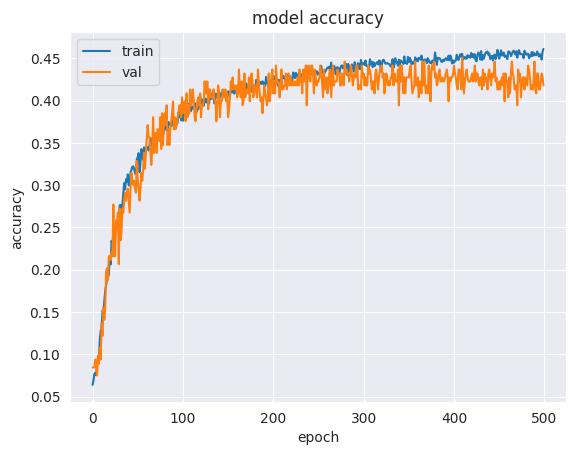

In [10]:
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',
            'val'
            ], loc='upper left')
plt.show()

pd.DataFrame(hist.history).to_csv(model_dir / "train_val_results.csv")

In [11]:
results = model.evaluate(val_data, val_labels, batch_size=1)
print("test loss, test acc:", results)
with open(model_dir / "test_results.json", "w") as res_file:
    json.dump(results, res_file)

213/213 [==============================] - 0s 778us/step - loss: 2.4234 - sparse_categorical_accuracy: 0.4178
test loss, test acc: [2.423410654067993, 0.4178403615951538]


7/7 [==============================] - 0s 1ms/step


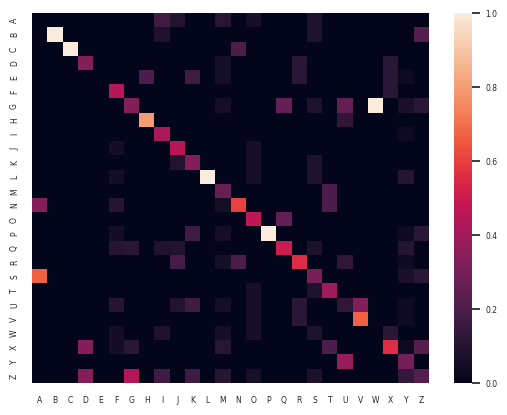

In [12]:
y_prediction = model.predict(val_data)
y_prediction = np.argmax(y_prediction, axis=1)
# y_test = np.argmax(val_labels)
#Create confusion matrix and normalizes it over predicted (columns)
result = sklearn.metrics.confusion_matrix(val_labels, y_prediction, normalize='pred')

letters = list(string.ascii_uppercase)
df_cm = pd.DataFrame(result, letters, letters)
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm) # font size
plt.savefig(model_dir / "images/confusion_matrix.png")
plt.show()

In [13]:
reverse_label_map = {v: k for k, v in label_map.items()}

In [14]:
index = 300
print(reverse_label_map[labels[index]])
reverse_label_map[np.argmax(model.predict(np.array([data[index]])))]

D
1/1 [==============================] - 0s 18ms/step


'O'

In [15]:
model.save(model_dir / "asl-now.keras")
model.save_weights(model_dir / "asl-now-weights.h5")

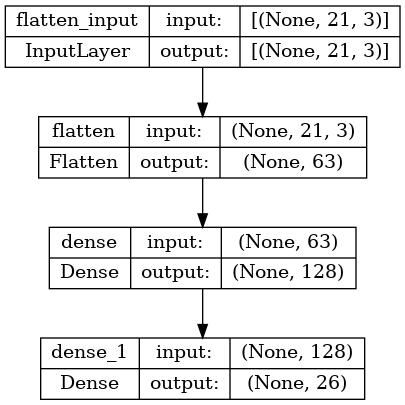

In [16]:
tf.keras.utils.plot_model(
    model,
    model_dir / "images/plotted_model.png",
    show_shapes=True,
)

In [17]:
visualkeras.layered_view(model).save(model_dir / "images/layered_model.png")

In [18]:
# model = tf.keras.models.load_model(model_dir / "asl-now.keras")

In [19]:
tfjs.converters.save_keras_model(model, model_dir / "tfjs-model")

/home/sid/PycharmProjects/asl-now/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Upload

In [20]:
%cd if_models
!git add .
!git commit -m "v{VERSION}"

/home/sid/PycharmProjects/asl-now/ml/if_models


/home/sid/PycharmProjects/asl-now/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[main 1c8ac59] v3
 9 files changed, 509 insertions(+)
 create mode 100644 asl-now-weights.h5
 create mode 100644 asl-now.keras
 create mode 100644 images/confusion_matrix.png
 create mode 100644 images/layered_model.png
 create mode 100644 images/plotted_model.png
 create mode 100644 test_results.json
 create mode 100644 tfjs-model/group1-shard1of1.bin
 create mode 100644 tfjs-model/model.json
 create mode 100644 train_val_results.csv
